In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import surprise
from surprise import Dataset
from surprise import Reader
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
movie_data = pd.read_csv('dataset/movie.csv')
rates_data = pd.read_csv('dataset/rating.csv')

In [3]:
movie_index = pd.Series(movie_data.index, index=movie_data.title)
movie_index.head()

title
Toy Story (1995)                      0
Jumanji (1995)                        1
Grumpier Old Men (1995)               2
Waiting to Exhale (1995)              3
Father of the Bride Part II (1995)    4
dtype: int64

In [4]:
print ("Data tabel anime berupa (row, column):"+ str(movie_data.shape))
print (movie_data.info())

Data tabel anime berupa (row, column):(9742, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


In [5]:
print ("Data tabel rate berupa (row, column):"+ str(rates_data.shape))
print (rates_data.info())

Data tabel rate berupa (row, column):(100836, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


In [6]:
film_fulldata = pd.merge(movie_data, rates_data, on='movieId',suffixes= ['', 'userId'])
film_fulldata = film_fulldata.rename(columns={'name': 'titles', 'rating_user': 'user_rating'})
film_fulldata.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


Text(0, 0.5, 'User Rating count')

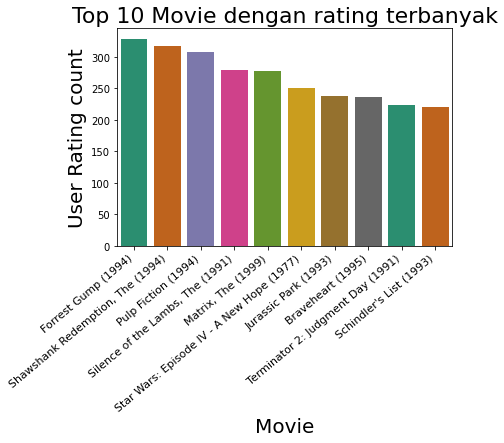

In [7]:
gabung_film_rates = film_fulldata.dropna(axis = 0, subset = ['title'])
film_rateCount = (gabung_film_rates.
                     groupby(by = ['title'])['rating'].
                     count().
                     reset_index().rename(columns = {'ratings': 'totalRatingCount'})
                     [['title', 'rating']]
                     )

top_movierate = film_rateCount[['title', 'rating']].sort_values(
    by = 'rating', ascending = False
).head(10)

ax = sns.barplot(x = "title", y = "rating", data = top_movierate, palette="Dark2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Movie dengan rating terbanyak', fontsize = 22)
ax.set_xlabel('Movie', fontsize = 20) 
ax.set_ylabel('User Rating count', fontsize = 20)

In [8]:
movie_data.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [9]:
rates_data.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [10]:
rates_data['user_movie_count'] = rates_data.groupby('userId')['movieId'].transform(np.count_nonzero)
rates_data.tail() 

,userId,movieId,rating,timestamp,user_movie_count
100831,610,166534,4.0,1493848402,1302
100832,610,168248,5.0,1493850091,1302
100833,610,168250,5.0,1494273047,1302
100834,610,168252,5.0,1493846352,1302
100835,610,170875,3.0,1493846415,1302


In [11]:
film_feature = film_fulldata.copy()
film_feature["rating"].replace({-1: np.nan}, inplace=True)
film_feature.head()

film_feature = film_feature.dropna(axis = 0, how ='any') 
film_feature.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [12]:
movie_pivot = film_feature.pivot_table(index='title',
                                      columns='userId',
                                      values='rating'
                                     ).fillna(0)
movie_pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
movie_matrix = csr_matrix(movie_pivot.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [14]:
TfV = TfidfVectorizer(min_df=3,  max_features=None, 
                      strip_accents = 'unicode', 
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range = (1, 3),
                      stop_words = 'english')
movie_data['genres'] = movie_data['genres'].fillna('')
genres_str = movie_data['genres'].str.split(',').astype(str)
tfv_matrix = TfV.fit_transform(genres_str)

In [15]:
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)
indices = pd.Series(movie_data.index, index=movie_data['title']).drop_duplicates()

In [16]:
def minta_rec(title, sig=sig):
    # ambil index title anime
    idx = indices[title]

    # mengambil score
    sig_scores = list(enumerate(sig[idx]))

    # urutin movie dgn score 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    sig_scores = sig_scores[1:11]

    # Movie indices
    movie_indices = [i[0] for i in sig_scores]

    # Top 10 anime movie
    return pd.DataFrame({'Nama Movie': movie_data['title'].iloc[movie_indices].values,
                         'Genre': movie_data['genres'].iloc[movie_indices].values
                        })

In [17]:
minta_rec('I, Robot (2004)')

,Nama Movie,Genre
0,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
1,Escape from L.A. (1996),Action|Adventure|Sci-Fi|Thriller
2,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller
3,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi|Thriller
5,Star Trek II: The Wrath of Khan (1982),Action|Adventure|Sci-Fi|Thriller
6,"Lost World: Jurassic Park, The (1997)",Action|Adventure|Sci-Fi|Thriller
7,Spawn (1997),Action|Adventure|Sci-Fi|Thriller
8,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller
9,Moonraker (1979),Action|Adventure|Sci-Fi|Thriller
